In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from train_multiview_network import TrainMultiInputModel
from multi_view_classification_network import MultiInputModel
from testMV_GC import GradCam
from visualisation_utils import image_net_postprocessing
from config import get_config
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from pytorch_grad_cam_adapt.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam_adapt.image import scale_cam_image, tensor2cam, subplot, vis_outs2images_classes,image2cam,tensor2img, show_cam_on_image
from pytorch_grad_cam_adapt.model_targets import ClassifierOutputTarget
from pytorch_grad_cam_adapt.grad_cam import GradCAM
from torchvision.models import resnet50

In [11]:
torch.cuda.empty_cache()
model_config, data_config = get_config()
trainer = TrainMultiInputModel(model_config,data_config)
model_recto = model_config['model_recto']
model_verso =   model_config['model_verso']            
model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=model_config['fine_tune'], num_classes=7)
checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_EfficientNet_model_verso_VGG_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
print('Loading trained model weights...')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(trainer.device)

lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)

input_recto, real = trainer.datasetRecto_test[0]
input_verso = trainer.datasetVerso_test[0][0]
input_recto = input_recto.unsqueeze(0).to('cuda')
input_verso = input_verso.unsqueeze(0).to('cuda')

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning last features layers...
[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning last features layers...
Loading trained model weights...


In [4]:
model.eval()
model([input_recto,input_verso])

tensor([[-2.0820,  0.3509,  2.7175, -1.6694, -2.4304, -2.0160, -4.0544]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [12]:
def get_guided_gram_from_images(vis,model,rectoImageTensor,versoImageTensor, real_class, device='cuda'):
    input_recto = rectoImageTensor.unsqueeze(0).to(device)
    input_verso = versoImageTensor.unsqueeze(0).to(device)
    outs = [vis(input_tensors = [input_recto, input_verso],targets = None)]
    camRecto, camVerso ,classes = vis_outs2images_classes(outs)
    imagesRecto = image2cam(image_net_postprocessing(input_recto),camRecto[0][0])
    imagesVerso = image2cam(image_net_postprocessing(input_verso),camVerso[0][0])
    classes = le.inverse_transform(list(classes))
    real_label = le.inverse_transform([real_class])[0]  if real_class else "Non classée"
    subplot(images = [image_net_postprocessing(input_recto.squeeze().cpu()), imagesRecto,image_net_postprocessing(input_verso.squeeze().cpu()),imagesVerso],
            title=f'Recto EfficientNet Verso VGG16 real {real_label}, Predict : {classes[0]}',
            rows_titles=['Recto','Verso'],
            cols_titles = ['Original', 'GradCAM'],
            nrows=2, 
            ncols=2,
            parse = tensor2img
            )

In [21]:
target_layers = [[model.modelRecto.features[-1][0]],[model.modelVerso.features[-2]]]
input_tensors = [input_recto,input_verso]
#model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=False, num_classes=7)
#model.load_state_dict(checkpoint['model_state_dict'])
#model = model.to(trainer.device)
rgb_img = tensor2img(input_recto)/255
# Construct the CAM object once, and then re-use it on many images:
vis = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[<AxesSubplot: > <AxesSubplot: >]
[<AxesSubplot: > <AxesSubplot: >]


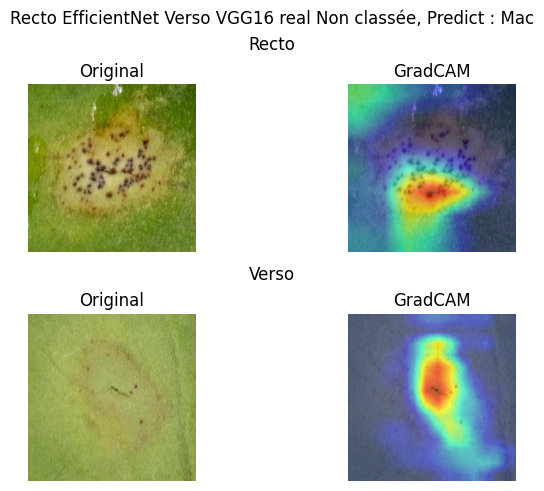

In [15]:

input_recto, real = trainer.datasetRecto_test[0]
input_verso = trainer.datasetVerso_test[0][0]
input_recto = input_recto.to('cuda')
input_verso = input_verso.to('cuda')
input_recto = input_recto.unsqueeze(0).to('cuda')
input_verso = input_verso.unsqueeze(0).to('cuda')
outs = [vis(input_tensors = [input_recto, input_verso],targets = None)]
camRecto, camVerso ,classes = vis_outs2images_classes(outs)
imagesRecto = image2cam(image_net_postprocessing(input_recto),camRecto[0][0])
imagesVerso = image2cam(image_net_postprocessing(input_verso),camVerso[0][0])
classes = le.inverse_transform(list(classes))
real_class = None
real_label = le.inverse_transform([real_class])[0]  if real_class else "Non classée"
subplot(images = [image_net_postprocessing(input_recto.squeeze().cpu()), imagesRecto,image_net_postprocessing(input_verso.squeeze().cpu()),imagesVerso],
        title=f'Recto EfficientNet Verso VGG16 real {real_label}, Predict : {classes[0]}',
        rows_titles=['Recto','Verso'],
        cols_titles = ['Original', 'GradCAM'],
        nrows=2, 
        ncols=2,
        parse = tensor2img)
torch.cuda.empty_cache()

In [20]:
camRecto[0][0][0]

array([0.460561  , 0.460561  , 0.460561  , 0.460561  , 0.460561  ,
       0.460561  , 0.460561  , 0.460561  , 0.460561  , 0.460561  ,
       0.460561  , 0.460561  , 0.460561  , 0.460561  , 0.460561  ,
       0.460561  , 0.45932376, 0.45684934, 0.45437488, 0.45190045,
       0.44942603, 0.44695154, 0.4444771 , 0.44200268, 0.43952826,
       0.4370538 , 0.43457937, 0.43210492, 0.42963046, 0.42715603,
       0.4246816 , 0.42220715, 0.4197327 , 0.41725826, 0.41478384,
       0.41230938, 0.40983495, 0.4073605 , 0.40488604, 0.4024116 ,
       0.39993718, 0.39746273, 0.3949883 , 0.39251384, 0.3900394 ,
       0.38756496, 0.38509053, 0.3826161 , 0.3791671 , 0.37474358,
       0.37032005, 0.36589652, 0.36147302, 0.35704947, 0.35262597,
       0.34820247, 0.3437789 , 0.3393554 , 0.33493188, 0.33050838,
       0.32608482, 0.32166132, 0.3172378 , 0.31281427, 0.30839077,
       0.30396724, 0.29954374, 0.29512018, 0.29069668, 0.28627315,
       0.28184962, 0.2774261 , 0.2730026 , 0.26857907, 0.26415